In [1]:
from tensorflow.keras import layers
from tensorflow import keras

from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os

EPOCH = 100
BATCH_SIZE = 16
LEARNING_RATE = 0.001

In [2]:
def createDirectory(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

def plot_model__hist(hist):
    path = './cheakpoint/lefms/' # loss, accuracy 그래프 저장할 path
    createDirectory(path)

    # loss 추이 그래프로 그려서 저장
    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['loss'], color='b', label="Training loss")
    plt.plot(hist.history['val_loss'], color='r', label="Validation loss")
    plt.savefig(path + 'model_loss_hist.png')
    plt.legend()
    plt.show()

    # accuracy 추이 그래프로 그려서 저장
    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['accuracy'], color='b', label="Training accuracy")
    plt.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
    plt.savefig(path + 'model_loss_hist.png')
    plt.legend(loc = "lower right")
    plt.show()

# Pre-processing data

In [3]:
wellbeing = pd.read_csv('./data/Wellbeing_and_lifestyle_data_Kaggle.csv')
wellbeing = wellbeing.drop('Timestamp', axis=1)
wellbeing = wellbeing.drop([10005]) 

age_dict = {'Less than 20' : 1, '21 to 35' : 2, '36 to 50' : 3, '51 or more' : 4}
wellbeing['AGE'] = pd.Series([age_dict[x] for x in wellbeing.AGE], index=wellbeing.index)

gender_dict = {'Female' : 1, 'Male' : 0}
wellbeing['GENDER'] = pd.Series([gender_dict[x] for x in wellbeing.GENDER], index=wellbeing.index)

wellbeing['DAILY_STRESS'] = wellbeing['DAILY_STRESS'].astype(int)

X = wellbeing.drop(['DAILY_STRESS', 'ACHIEVEMENT'], axis=1)
y = wellbeing[['DAILY_STRESS', 'ACHIEVEMENT']]

In [4]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 42, test_size=0.33)
print(f'''
Train X shape : {train_X.shape}
Train y shape : {train_y.shape}

Test X shape : {val_X.shape}
Test y shape : {val_y.shape}
''')


Train X shape : (10700, 21)
Train y shape : (10700, 2)

Test X shape : (5271, 21)
Test y shape : (5271, 2)



# Model building

In [5]:
lefms = keras.Sequential([
    layers.Conv1D(64, 3, padding='same', input_shape=(21, 1)),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),

    layers.Conv1D(64, 3, padding='same'),
    layers.Conv1D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),
    layers.MaxPool1D(pool_size=(2), strides=2),
    
    layers.Conv1D(32, 3, padding='same'),
    layers.Conv1D(32, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),
    layers.MaxPool1D(pool_size=(2), strides=2),
    
    layers.Conv1D(32, 3, padding='same'),
    layers.Conv1D(32, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),
    layers.MaxPool1D(pool_size=(2), strides=2),
    
    layers.Conv1D(16, 3, padding='same'),
    layers.Conv1D(16, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),
    layers.MaxPool1D(pool_size=(2), strides=2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-25 20:36:07.145395: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-25 20:36:07.145532: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
adam = keras.optimizers.Adam(
        learning_rate=0.00000001
)

lefms.compile(
        optimizer=adam,
        loss='binary_crossentropy',
        metrics=['accuracy']
)

lefms.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 21, 64)            256       
                                                                 
 batch_normalization (BatchN  (None, 21, 64)           256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 21, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 21, 64)            12352     
                                                                 
 conv1d_2 (Conv1D)           (None, 21, 64)            12352     
                                                                 
 batch_normalization_1 (Batc  (None, 21, 64)           256       
 hNormalization)                                        

In [7]:
outDir = './cheakpoint/lefms_model/' # 이 경로에 best 모델이 저장된다.
model_names = outDir + 'weights-{val_accuracy:.4f}.h5'
def get_callbacks(patience = 50):
    earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=patience)
    model_checkpoint = ModelCheckpoint(model_names, monitor='val_accuracy', verbose=1, save_best_only=True, period = 1)
  
    # callbacks = [earlystop, model_checkpoint]     # earlystop 사용하고 싶으면 이거 풀고 아래꺼 주석 처리
    callbacks = [model_checkpoint]

    return callbacks

In [8]:
callbacks = get_callbacks()
model_history = lefms.fit(
    train_X, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCH,
    validation_data=(val_X, val_y),
    callbacks=[callbacks]
)

Epoch 1/100


2022-12-25 20:36:07.588320: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-25 20:36:08.343881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


669/669 [==============================] - ETA: 0s - loss: -0.1355 - accuracy: 0.4722

2022-12-25 20:36:23.642564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.46063, saving model to ./cheakpoint/lefms_model/weights-0.4606.h5
669/669 [==============================] - 18s 25ms/step - loss: -0.1355 - accuracy: 0.4722 - val_loss: -0.1344 - val_accuracy: 0.4606
Epoch 2/100
667/669 [============================>.] - ETA: 0s - loss: -0.1451 - accuracy: 0.4756
Epoch 2: val_accuracy improved from 0.46063 to 0.47676, saving model to ./cheakpoint/lefms_model/weights-0.4768.h5
669/669 [==============================] - 16s 23ms/step - loss: -0.1452 - accuracy: 0.4759 - val_loss: -0.1436 - val_accuracy: 0.4768
Epoch 3/100
669/669 [==============================] - ETA: 0s - loss: -0.1540 - accuracy: 0.4834
Epoch 3: val_accuracy improved from 0.47676 to 0.47847, saving model to ./cheakpoint/lefms_model/weights-0.4785.h5
669/669 [==============================] - 16s 23ms/step - loss: -0.1540 - accuracy: 0.4834 - val_loss: -0.1481 - val_accuracy: 0.4785
Epoch 4/100
669/669 [==============================] - E

# Visualization results

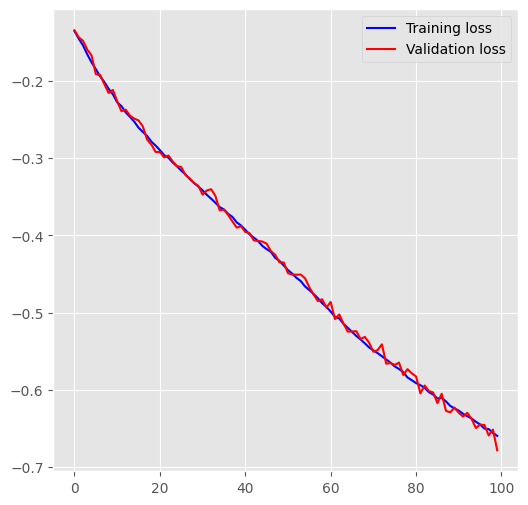

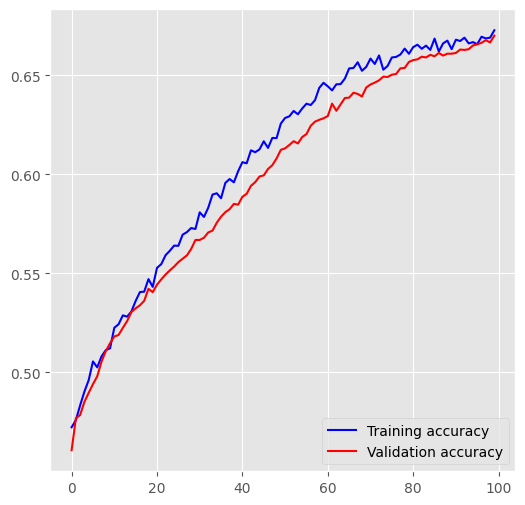

165/165 - 3s - loss: -6.7845e-01 - accuracy: 0.6701 - 3s/epoch - 16ms/step
multi_model의 정확도: 67.01%
multi_model의 Loss: -0.6784491539001465


In [9]:
plot_model__hist(model_history)
loss,acc = lefms.evaluate(val_X, val_y, verbose=2)
print("multi_model의 정확도: {:5.2f}%".format(100*acc))
print("multi_model의 Loss: {}".format(loss))

# Recall models, test

In [13]:
model_saved_path = './cheakpoint/lefms_model/'

recall_model_path = model_saved_path + sorted(os.listdir(model_saved_path))[-1]
reconstructed_model = keras.models.load_model(recall_model_path)
print(f"Recalled model path : {recall_model_path}")

Recalled model path : ./cheakpoint/lefms_model/weights-0.6701.h5


In [14]:
y_pred = reconstructed_model.predict(val_X)

2022-12-25 21:20:18.939398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


165/165 [==============================] - 2s 8ms/step


In [17]:
print(val_y)

       DAILY_STRESS  ACHIEVEMENT
10731             5            0
476               5            1
4291              3            4
1402              2            6
6497              1           10
...             ...          ...
4219              1            8
8086              4            8
13708             2           10
12286             1            3
8798              3            6

[5271 rows x 2 columns]
